Modified from wikipedia_topic_modeling; make scatter plots for LSI and LDA models

In [1]:
import sys, os
from xml.dom import minidom
import nltk
import pandas as pd

from collections import defaultdict
from gensim import corpora, models, similarities

%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

C:\Users\melanie\Anaconda3\envs\cdips2017\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir('..\data')

In [3]:
def get_page_type(title):
    """
    from WikiPage.py: extract page type from article title
    """
    if 'Category:' in title:
        return 'category'
    elif 'Portal:' in title:
        return 'portal'
    elif 'List of' in title:
        return 'list'
    elif 'File:' in title:
        return 'file'
    else:
        return 'article'

def xml_to_df(xmlfile):
    """
    input: xml filename
    output: data frame with columns: article id, title, url, page_type, tokenized text
    
    filter out pages that are not articles
    """
    xmldoc = minidom.parse(xmlfile)
    idlist = xmldoc.getElementsByTagName('id')
    titlelist = xmldoc.getElementsByTagName('title')
    textlist = xmldoc.getElementsByTagName('text')
    
    titles = [title.childNodes[0].data for title in titlelist]
    urllist = ['https://en.wikipedia.org/wiki/%s' % (title.replace(' ', '_'))
              for title in titles]
    typelist = [get_page_type(title) for title in titles]
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    
    word_data = [(id.childNodes[0].data, title, url, page_type,
                  tokenizer.tokenize(text.childNodes[0].data.lower()))
                for id, title, url, page_type, text in zip(idlist, titles, urllist, typelist, textlist)
                if page_type == 'article']
    word_data_df = pd.DataFrame(word_data, columns=['id', 'title', 'url', 'type', 'words'])
    #word_data_df.to_csv('word_data_df.csv')
    return(word_data_df)

In [4]:
xmlfile = 'Wikipedia-dog.xml'
df1 = xml_to_df(xmlfile)
xmlfile = 'Wikipedia-fish.xml'
df2 = xml_to_df(xmlfile)
word_data_df = df1.append(df2)
del df1, df2
word_data_df.head()

,id,title,url,type,words
0,5957048,Kennel,https://en.wikipedia.org/wiki/Kennel,article,"[about, shelter, for, dogs, and, cats, for, th..."
1,729436,Cynology,https://en.wikipedia.org/wiki/Cynology,article,"[cynology, ipac, en, s, ᵻ, ˈ, n, ɒ, l, ə, dʒ, ..."
2,1764821,Pack (canine),https://en.wikipedia.org/wiki/Pack_(canine),article,"[other, uses, wolfpack, disambiguation, image,..."
3,547372987,Rare breed (dog),https://en.wikipedia.org/wiki/Rare_breed_(dog),article,"[for, a, list, of, rare, dog, breeds, category..."
4,547375119,Dogs in ancient China,https://en.wikipedia.org/wiki/Dogs_in_ancient_...,article,"[refimprove, date, december, 2008, originalres..."


In [5]:
word_data_df.tail()

,id,title,url,type,words
14,747943497,Whale feces,https://en.wikipedia.org/wiki/Whale_feces,article,"[file, whalepump, jpg, thumb, 400px, right, wh..."
15,25152539,Whale watching in New Zealand,https://en.wikipedia.org/wiki/Whale_watching_i...,article,"[use, dmy, dates, date, may, 2017, file, whale..."
16,25152539,Tail sailing,https://en.wikipedia.org/wiki/Tail_sailing,article,"[file, southern, right, whale4, jpg, thumb, up..."
17,49437687,Bubble net feeding,https://en.wikipedia.org/wiki/Bubble_net_feeding,article,"[main, cetacean, surfacing, behaviour, bubble,..."
18,6736011,Ethelbert (whale),https://en.wikipedia.org/wiki/Ethelbert_(whale),article,"[no, footnotes, date, june, 2017, ethelbert, w..."


In [6]:
def make_dictionary(documents):
    """
    construct a dictionary, i.e. mapping btwn word ids and their freq of occurence in the whole corpus
    filter dictionary to remove stopwords and words occuring < min_count times
    
    input: documents is an iterable consisting of all the words in the corpus 
    output: filtered dictionary
    """
    dictionary = corpora.Dictionary(documents)

    stop_words = nltk.corpus.stopwords.words('english') 
    min_count = 2
    stop_ids = [dictionary.token2id[word] for word in stop_words
               if word in dictionary.token2id]
    rare_ids = [id for id, freq in dictionary.dfs.items()
                if freq < min_count]
    dictionary.filter_tokens(stop_ids + rare_ids)
    dictionary.compactify()
    return(dictionary)

def make_corpus(word_data_df):
    """
    """
    documents = word_data_df['words'].values
    dictionary = make_dictionary(documents)
    # convert corpus to vectors using bag-of-words representation, i.e. tuples of word indices and word counts
    corpus = [dictionary.doc2bow(words) for words in documents]
    return(corpus, dictionary)

def make_lsi_similarity_matrix(tfidf_corpus, dictionary):
    """
    construct LSI (latent semantic indexing) model on Tfidf-transformed corpus, print model topics, 
    return similarity matrix.
    """
    # construct model
    lsi = models.lsimodel.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=200) 
    lsi.save('wiki.lsi')
    # create similarity matrix
    matsim = similarities.MatrixSimilarity(lsi[tfidf_corpus], num_best=6)
    return(matsim)

def make_lda_similarity_matrix(corpus, dictionary):
    """
    Latent Dirichlet Allocation (LDA) model
    """
    # construct model
    lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=200)
    lda.save('wiki.lda')
    # create similarity matrix
    matsim = similarities.MatrixSimilarity(lda[corpus], num_best=6)
    return(matsim)

In [7]:
corpus, dictionary = make_corpus(word_data_df)
tfidf = models.TfidfModel(corpus)
lsi_matsim = make_lsi_similarity_matrix(tfidf[corpus], dictionary)
lda_matsim = make_lda_similarity_matrix(corpus, dictionary)

In [8]:
# plot projection of articles onto 2 axes/topics defined by the model; for models operating on tfidf-transformed inputs (LSI, RP)
def plot_axes_with_tfidf(x, y, model, corpus, tfidf, titles):
    """Plot each article title according to the projection of its text 
    into the given x and y topic axes of model.
    
    :param x: the index of the x axis to plot
    :param y: the index of the y axis to plot
    :param model: the gensim model to project into
    :param corpus: the gensim corpus of documents
    :param tfidf: a tfidf model for converting documents into tfidf space
    :param titles: a list of article titles
    """
    x_data = defaultdict(list) 
    y_data = defaultdict(list) 
    arts = defaultdict(list)  
    for title, doc in zip(titles, corpus):
        x_data[0].append((model[tfidf[doc]][x][1]))
        y_data[0].append((model[tfidf[doc]][y][1]))
        arts[0].append(title)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_xlabel('Topic '+str(x), fontsize=14)
    ax.set_ylabel('Topic '+str(y), fontsize=14)
    plt.scatter(x_data[0], y_data[0], s=40)
    for art, x, y in zip(arts[0], x_data[0], y_data[0]):
        ax.annotate(str(art), xy=(x, y), xycoords='data', xytext=(1, 1), 
        textcoords='offset points', size=10)
    
        
# plot projection of articles onto 2 axes/topics defined by the model; for models operating on original corpus (LDA, HDP)
def plot_axes(x, y, model, corpus, titles):
    """Plot each article title according to the projection of its text 
    into the given x and y topic axes of model.
    
    :param x: the index of the x axis to plot
    :param y: the index of the y axis to plot
    :param model: the gensim model to project into
    :param corpus: the gensim corpus of documents
    :param titles: a list of article titles
    """
    x_data = defaultdict(list) 
    y_data = defaultdict(list) 
    arts = defaultdict(list)  
    for title, doc in zip(titles, corpus):
        x_data[0].append((model[doc][x][1]))
        y_data[0].append((model[doc][y][1]))
        arts[0].append(title)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_xlabel('Topic '+str(x), fontsize=14)
    ax.set_ylabel('Topic '+str(y), fontsize=14)
    plt.scatter(x_data[0], y_data[0], s=40)
    for art, x, y in zip(arts[0], x_data[0], y_data[0]):
        ax.annotate(str(art), xy=(x, y), xycoords='data', xytext=(1, 1), 
        textcoords='offset points', size=10)  

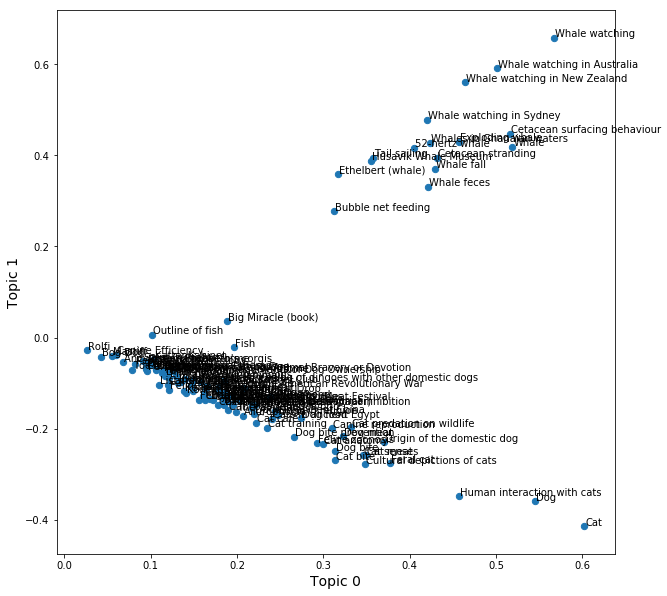

In [9]:
lsi = models.LsiModel.load('wiki.lsi')
titles = word_data_df['title']
plot_axes_with_tfidf(x=0, y=1, model=lsi, corpus=corpus, tfidf=tfidf, titles=titles)

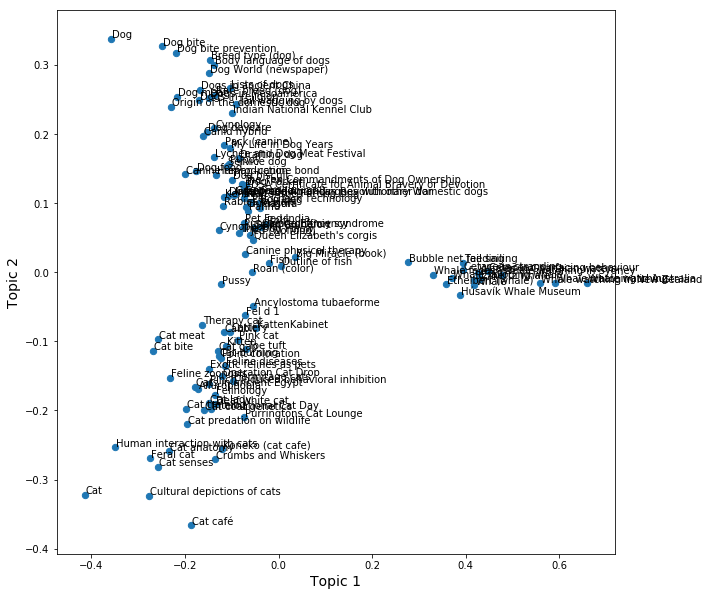

In [10]:
plot_axes_with_tfidf(x=1, y=2, model=lsi, corpus=corpus, tfidf=tfidf, titles=titles)

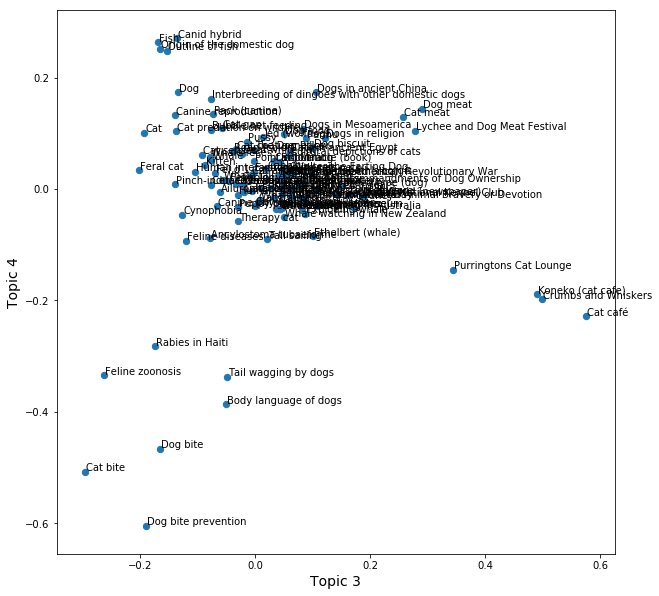

In [11]:
plot_axes_with_tfidf(x=3, y=4, model=lsi, corpus=corpus, tfidf=tfidf, titles=titles)

In [12]:
lda = models.LdaModel.load('wiki.lda')

In [13]:
plot_axes(x=0, y=1, model=lda, corpus=corpus, titles=titles)

IndexError: list index out of range

In [14]:
# LSI result is ordered
for doc in corpus:
    temp=lsi[doc]
    print(temp)

[(0, 9.7706503521790449), (1, -7.9235394339841214), (2, 5.142825596789506), (3, 6.3948263190411714), (4, -1.5792639685965402), (5, 0.8336171257042766), (6, -6.8984171906463585), (7, 12.744400967613497), (8, -4.2839395446023207), (9, 3.5273453886653288), (10, 0.70046297286618742), (11, -4.3570617293643084), (12, 1.274580234435446), (13, -6.3994626906437206), (14, 2.7345856260296681), (15, -3.4446431584534447), (16, 7.7109719026902894), (17, -0.46543600749110492), (18, 2.2220060285201275), (19, -6.1812422032045307), (20, 4.090175236668161), (21, 0.0063278318810435982), (22, -1.1753614689763798), (23, 1.3960154363057662), (24, -0.93969268911999182), (25, 0.29385677920325809), (26, 0.79555915911455644), (27, 1.1953513952395312), (28, -0.34328767216205608), (29, -0.81836830465684085), (30, -1.2954323942128827), (31, -0.082589696285216452), (32, 1.0764434517385142), (33, 0.39402924931465977), (34, 0.26163749586644919), (35, -0.60928829846383181), (36, 0.16518111681558745), (37, -0.1044153054

In [15]:
# LDA result is unordered
for doc in corpus:
    temp=lda[doc]
    print(temp)

[(0, 0.079914125540900396), (28, 0.09640090350396574), (61, 0.27685054016614319), (89, 0.15017043019088053), (118, 0.065271837503240823), (163, 0.03071369338221891), (199, 0.29794475866449344)]
[(91, 0.069797800922072273), (98, 0.83236569547262396), (118, 0.074861319431939979), (199, 0.018369424524075802)]
[(17, 0.044137109214976378), (118, 0.016236603718255218), (150, 0.93886566930614646)]
[(108, 0.99816081330868844)]
[(0, 0.22919549216708943), (17, 0.067558739422865624), (25, 0.040089720079683103), (68, 0.023907720565957944), (98, 0.014751853256144925), (118, 0.15902979168990827), (152, 0.021511167286645531), (160, 0.4146832387310454)]
[(42, 0.050587295175244427), (68, 0.041253842526023557), (73, 0.55783745791935391), (87, 0.028976172609127618), (91, 0.079419608505400682), (118, 0.093511932217522617), (152, 0.010254784524820069), (160, 0.11623540067875077)]
[(61, 0.030652569307097696), (87, 0.73385535663316348), (114, 0.20342516524772672), (199, 0.025582717984279482)]
[(61, 0.0466041

[(41, 0.30094894976335246), (118, 0.43944006829187165), (152, 0.055964810887315017), (160, 0.066920372812790785), (166, 0.022634090796214323), (179, 0.031008433810655392)]
[(40, 0.16840282362010589), (97, 0.061290121230075698), (118, 0.60007481750853309), (128, 0.011871387523533066), (152, 0.019436413658071024), (162, 0.039356786303226345), (179, 0.085892700593935389)]
[(11, 0.01440980642355846), (41, 0.26742554954294495), (118, 0.59079370189964275), (160, 0.096771460510041471), (190, 0.020421821080852935)]
[(41, 0.096780163860192642), (118, 0.89554158918563531)]
[(118, 0.98256197613415086)]
[(41, 0.99798582995951568)]
[(118, 0.544602569903615), (125, 0.45450473369693439)]
[(9, 0.54415047667984651), (118, 0.050771176150631592), (167, 0.40361257335999923)]
[(9, 0.019774912660841332), (41, 0.32273491109396552), (118, 0.32975325083671275), (152, 0.23050619447569198), (162, 0.013100114165819887), (179, 0.044372180412677507)]
[(40, 0.035409652907647055), (41, 0.038179595538842148), (118, 0.